---
title: Injective Networks
subtitle: The Central Idea behind Neural Injective Geometry
date: 2025-02-25
---

# Neural Injective Curves
We now discuss the abstract idea behind our shape parameterization to represent general simple
closed curves in the plane. As we shall see, this approach is conceptual and to actually create
curves a construction method is needed. Our method is based on neural networks with special
architectures that work as construction methods. We will see that the basic neural network
architecture is a very natural approach for constructing non-self-intersecting curves.

## Cartesian Neural Injective Curves

Consider the following parameterization to represent curves:
\begin{align*}
x &= f(t)\\
y &= g(t), \quad t \in [0, 1]
\end{align*}
This representation can potentially represent any curve in the plane not necessarily simple and
closed.  Thus it is *too broad*, we want the functions $f$ and $g$ to be such that we only
represent **simple** and **closed** curves. Refer [](#curve_types) for a visual understanding of
simple closed curves.

:::{figure} assets/curve_types.svg
:alt: Four types of curves: simple/not simple + closed/not closed
:label: curve_types
:height: 270px
We will be concerned with simple closed curves, i.e. curves that loop back and do not
self-intersect.
:::

Simple
: A curve is simple if it does not self-intersect. That is, two different $t$ values should not map
to the same point in the plane. Mathematically,
$$
t_1 \neq t_2 \implies (x(t_1), y(t_1)) \neq (x(t_2), y(t_2))
$$

Closed
: A curve is *closed* if the starting and the ending points are the same. Mathematically,
$$
(x(0), y(0)) = (x(1), y(1))
$$

If these additional constraints are satisfied by the functions $f$ and $g$ then the curves
generated will be guaranteed to be simple closed curves. We now discuss a way of constructing
functions $f$ and $g$ such that they always satisfy these constraints.

To create a construction mechanism we need to first look at the problem differently through a single
vector-valued mapping instead of two scalar-valued functions $f$ and $g$. Consider also, instead of
two scalar values $x$ and $y$, a single vector which has the two values stacked $[x, y]^{T}$.
This vector is parameterized as before through a parameter $t$. Concretely, consider a vector-valued
mapping $F$ that maps $t$ to the vector of $x$ and $y$.
:::{math}
F: t \rightarrow
\begin{bmatrix}
x\\
y
\end{bmatrix}
:::

### Condition 1 - Simple Curves
For the curves represented through the mapping $F$ to be simple, we need $F$ to be an
[injective](https://en.wikipedia.org/wiki/Injective_function) map as then every $t$ value will map
to a different point in the plane and does not self-intersect. We will now see how neural networks
are quite naturally suited for this.

Consider the specific neural network architecture shown in
[](neural_network_architecture_injective):
:::{figure} assets/neural_network_architecture_injective.svg
:label: neural_network_architecture_injective
:alt: Figure showing a basic neural network architecture that preserves injectivity at each layer.
:height: 210px
If each layer is injective then the composition of these i.e. the entire network will also be
injective.
:::

We now see each transformation of the network one by one. At the first layer the mapping from $t$ to
a vector $At$ of $\dim 2$ is performed by a column vector $A$ and is one-to-one. The next mapping
by a non-linear activation function $\sigma(z)$ is an element-wise mapping. If we choose our
activation function to be an injective function, such as the sigmoid, PReLU, ELU etc. then the
mapping it produces from one vector to the next will also be injective. Note here that we cannot use
the ReLU as it is not an injective function. Now consider the mapping from a $\dim 2$ vector to
another produced by some $2 \times 2$ matrix $B$. *This mapping is injective with probability 1!*
[^injective_matrix_probability]. That is, if we generate a random $2 \times 2$ matrix $B$ then it is
injective with probability 1. The neural network is composed of these linear and non-linear mappings
in a sequence. Since the composition of two injective mappings is injective[^injective_composition],
the entire network is injective as a whole. Thus the mapping $F$ from $t$ to $[x, y]^{T}$ is an
injective map. Hence, the curves produced by it will be simple curves.

:::{important} Crucial: Hidden layer size 2
A neural network constructed as above is injective with *probability 1*. The critical information
used in the construction of the network was that we maintain a hidden layer size of 2 which leads to
the matrices $B$ being injective. If we had produced larger hidden layers, say of size $m$, then we
would eventually have to reduced the size back to 2 because our output is a $\dim 2$ vector
representing $x$ and $y$ and a $m \times 2$ matrix that would produce this would not be injective in
most cases.
:::

[^injective_matrix_probability]: A square $n \times n$ matrix is injective if and only if it is
    invertible.
    > Singular matrices are rare in the sense that if a square matrix's entries are randomly
    selected from any bounded region on the number line or complex plane, the probability that the
    matrix is singular is 0, that is, it will "almost never" be singular.
    >
    > -- [Wikipedia, Invertible Matrix](https://en.wikipedia.org/wiki/Invertible_matrix#Definition)

[^injective_composition]: Composition of two injective functions $f$ and $g$, $f \circ g$ is also
    injective.
    [Wikipedia, Injective function](https://en.wikipedia.org/wiki/Injective_function#Other_properties)

(closed_transformation)=
### Condition 2 - Closed Curves
For the curves represented through $F$ to be closed, we need the $x$ and $y$ values to be the same
at $t = 0, 1$. Note, that this has to be in-built into the mapping without affecting the injectivity
property that we achieved before. One way is to first produce the transformation:
:::{math}
C(t) = 
\begin{bmatrix}
cos(2\pi t)\\
sin(2\pi t)
\end{bmatrix}
:::

This mapping is injective for $t \in [0, 1)$ and also satisfies $C(0) = C(1)$. Therefore, we use
this as the first transformation before applying the linear and non-linear activation layers. The
modified neural network architecture is shown in
[](#neural_network_architecture_injective_and_closed):

:::{figure} assets/neural_network_architecture_injective_and_closed.svg
:label: neural_network_architecture_injective_and_closed
:alt: Figure showing a modified neural network architecture that produces closed curves.
:height: 210px
This modified neural network architecture produces closed curves. Also, since the entire network is
injective the curves produced will also be non-self-intersecting.
:::

We now have $F(0) = F(1)$ and the mapping $F$ is also injective with probability 1!

```{card}
We call this architecture the **_Injective Network_**.
```

### Implementation
We first do a basic implementation of an Injective Network.

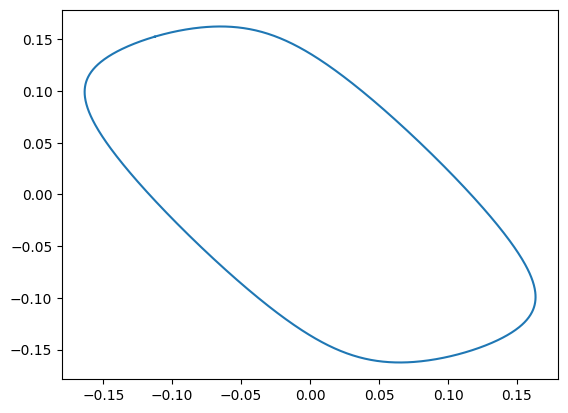

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

def injective_net(t):
    # Perform the transformation for closed curves
    z = np.hstack([np.cos(2 * np.pi * t), np.sin(2 * np.pi * t)])
    a = np.tanh(z)

    # Perform the linear and non-linear transformations
    layer_count = 2
    for i in range(layer_count):
        # We subtract 0.5, without it the shapes will be extremely thin like lines
        A = np.random.random((2, 2)) - 0.5
        z = a @ A
        a = np.tanh(z)
    
    return a

num_pts = 1000
t = np.linspace(0, 1, num_pts).reshape(-1, 1)

X = injective_net(t)

plt.plot(X[:, 0], X[:, 1])
plt.show()

Now we generate random shapes to get a flavor of the variety of shapes that the parameterization can
represent. Click the {kbd}`Generate Curve` button below to initialize random $A$ matrices and
visualize the resulting curves. The activation function used is `LeakyReLU` and it's a 2 layer deep
Injective Network.

Also, notice that the generated curve never self intersects.

:::{code-cell} ipython3
:tags: [hide-input]

import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import Button, VBox, Output, Layout
from IPython.display import display

def LeakyReLU(x, alpha = 0.1):
    return np.maximum(alpha * x, x)

def injective_net(t):
    # Perform the transformation for closed curves
    z = np.hstack([np.cos(2 * np.pi * t), np.sin(2 * np.pi * t)])
    a = LeakyReLU(z)

    # Perform the linear and non-linear transformations
    layer_count = 2
    for i in range(layer_count):
        A = np.random.random((2, 2)) - 0.5
        z = a @ A
        a = LeakyReLU(z)
    
    return a

# Create an output widget to display the plot
output = Output()

# Function to execute when the button is clicked
def generate_plot(_):
    with output:
        output.clear_output(wait = True)  # Clear previous output for fresh plot
        num_pts = 1000
        t = np.linspace(0, 1, num_pts).reshape(-1, 1)

        X = injective_net(t)

        # Plot the result
        plt.plot(X[:, 0], X[:, 1])
        plt.show()

# Create a button widget
button = Button(
    description = "Generate Curve",
)
button.on_click(generate_plot)

# Display the button and output together
display(VBox([button, output]))
:::

## Fitting Target Curves: Curve Similarity Metrics
Now that we have a shape parameterization method that represents only simple closed curves, we would
like to fit it to target shapes. This is useful in various scenarios: starting an optimization from
a particular initial shape, exploring the representative power of a given depth network, the effect
of activation functions on the types of shapes that we can represent etc.

Let's say we have a target shape specified (say the Stanford Bunny[^stanford_bunny]) and we want our
parameterization to represent that shape as closely as possible. To represent the given shape one
way would be to tune the parameters of the representation scheme iteratively using a gradient descent
optimization approach. This requires us to define an objective function that can then be optimized
over. An appropriate objective for this task would be some measure of similarity(or dissimilarity)
between the target curve and the one traced out by our parameterization. The objective function can
then be maximized(or minimized) to fit the parameters.

For details on similarity metrics refer to the tutorial on
[Geometric Similarity Measures](https://atharvaaalok.github.io/geosimilarity/geometric-similarity-measures)
described on the webpage of [geosimilarity](https://github.com/atharvaaalok/geosimilarity), the
geometric loss function library we will use.

Here we will assume that we have some curve similarity measures available to us defined as loss
functions in PyTorch. We will use these directly to fit shapes. In particular we have the following
setup:
:::{table} The optimization problem setup
:label: optimization_problem_setup
:align: center

|Object|Details|
|---|---|
|Shape Parameterization|Injective Net with parameters $\phi$
|Candidate/Parameterized Curve|Sampled at discrete $t \in [0, 1]$ from Injective Net, stored in $N_c\times 2$ matrix $X_c$|
|Target Curve|Specified curve to fit, stored in $N_t \times 2$ matrix $X_t$|
|Loss Function|$\mathcal{L}(X_t, X_c)$|

:::

Note that since $X_c$ is sampled from the network with parameters $\phi$ it is also a function of
$\phi$, $X_c = X_c(\phi)$.

**_Goal_**: Use automatic differentiation to get gradients of $\mathcal{L}(X_t, X_c)$ w.r.t.
$\phi$ and then run gradient descent and tune the parameters.

[^stanford_bunny]: The Stanford Bunny
    :::{image} assets/stanford_bunny.svg
    :alt: The Stanford Bunny shown as a target curve.
    :height: 250px
    :::
    The [Stanford Bunny](https://en.wikipedia.org/wiki/Stanford_bunny). We will use it as
    a target shape against which we test our parameterization techniques.

### Implementation

In [1]:
import torch
from torch import nn

class InjectiveNet(nn.Module):
    def __init__(self, layer_count, act_fn):
        super().__init__()

        # Define the transformation from t on the [0, 1] interval to unit circle for closed shapes
        self.closed_transform = lambda t: torch.hstack([
            torch.cos(2 * torch.pi * t),
            torch.sin(2 * torch.pi * t)
        ])

        layers = []
        for i in range(layer_count):
            layers.append(nn.Linear(2, 2))
            layers.append(act_fn())
        
        self.linear_act_stack = nn.Sequential(*layers)
    
    def forward(self, t):
        x = self.closed_transform(t)
        x = self.linear_act_stack(x)
        return x

Now we train Injective Networks to fit target shapes. In particular we use loss functions from the
[geosimilarity](https://github.com/atharvaaalok/geosimilarity) python package. Refer to the
[geosimilarity web tutorial](https://atharvaaalok.github.io/geosimilarity/) on API reference and
available geometric loss functions. We use shapes from the [shapes](./assets/shapes.py) python
module. We will use a circle and square as target shapes and the Mean Squared Error (MSE) loss
function to quantify the difference between the parameterized and the target curve.

We also use the [automate_training](./assets/utils.py)[^automate_training] function to
hide the training details and focus on the parameterization. The [plot_curve](./assets/utils.py)
function plots the target and the parameterized curves and abstracts away the plotting details.

[^automate_training]: The code used for automating the training of Networks is:
    :::{literalinclude} assets/utils.py
    :lines: 1-2, 5-28
    :::

Training Circle Net:
Epoch: [   1/1000]. Loss:    0.659884
Epoch: [ 200/1000]. Loss:    0.001520
Epoch: [ 400/1000]. Loss:    0.001250
Epoch: [ 600/1000]. Loss:    0.001164
Epoch: [ 800/1000]. Loss:    0.001135
Epoch: [1000/1000]. Loss:    0.001122
Training Square Net:
Epoch: [   1/1000]. Loss:    0.885124
Epoch: [ 200/1000]. Loss:    0.000301
Epoch: [ 400/1000]. Loss:    0.000236
Epoch: [ 600/1000]. Loss:    0.000223
Epoch: [ 800/1000]. Loss:    0.000218
Epoch: [1000/1000]. Loss:    0.000215


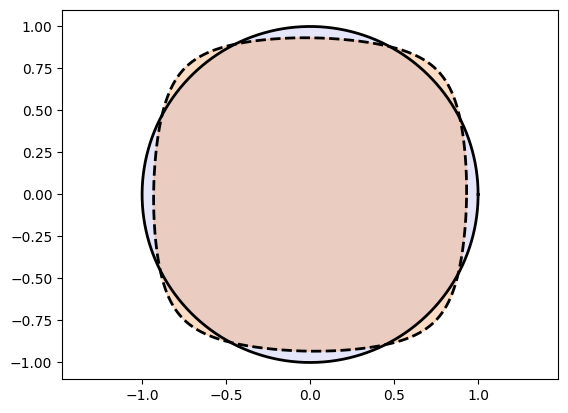

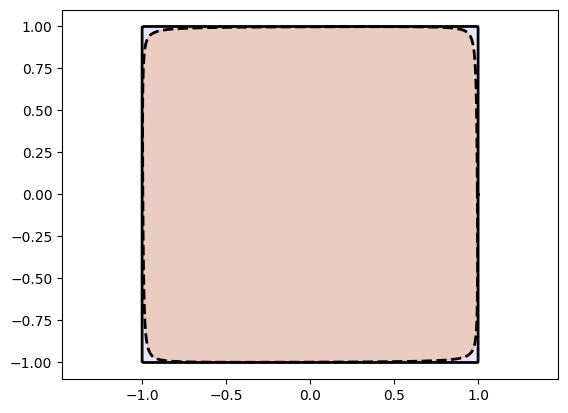

In [5]:
import geosimilarity as gs
from assets.shapes import circle, square
from assets.utils import automate_training, plot_curves

# Generate target curve points
num_pts = 1000
t = torch.linspace(0, 1, num_pts).reshape(-1, 1)
Xt_circle = circle(num_pts)
Xt_square = square(num_pts)

# Initialize networks to learn the target shapes and train
circle_net = InjectiveNet(layer_count = 3, act_fn = nn.Tanh)
square_net = InjectiveNet(layer_count = 3, act_fn = nn.Tanh)

print('Training Circle Net:')
automate_training(
    model = circle_net, loss_fn = gs.MSELoss(), X_train = t, Y_train = Xt_circle,
    learning_rate = 0.1, epochs = 1000, print_cost_every = 200
)
print('Training Square Net:')
automate_training(
    model = square_net, loss_fn = gs.MSELoss(), X_train = t, Y_train = Xt_square,
    learning_rate = 0.1, epochs = 1000, print_cost_every = 200
)

# Get final curve represented by the networks
Xc_circle = circle_net(t)
Xc_square = square_net(t)

# Plot the curves
plot_curves(Xc_circle, Xt_circle)
plot_curves(Xc_square, Xt_square)

Awesome! We see that we are doing good on simple shapes. Now we move onto something challenging.

Let's test the method on the Stanford Bunny. We will treat the Stanford Bunny as our recurring
evaluation target for different architectures. Therefore we will use a fixed number of points on the
target bunny curve to maintain consistency across curve fitting results.

We now try different `layer_count` and `act_fn` to try and fit the bunny. We recommend you to play
around with the code below to get a good feel for curve fitting capacity of Injective Networks.

Epoch: [   1/1000]. Loss:    0.326294
Epoch: [ 200/1000]. Loss:    0.173952
Epoch: [ 400/1000]. Loss:    0.044002
Epoch: [ 600/1000]. Loss:    0.030140
Epoch: [ 800/1000]. Loss:    0.026107
Epoch: [1000/1000]. Loss:    0.020798


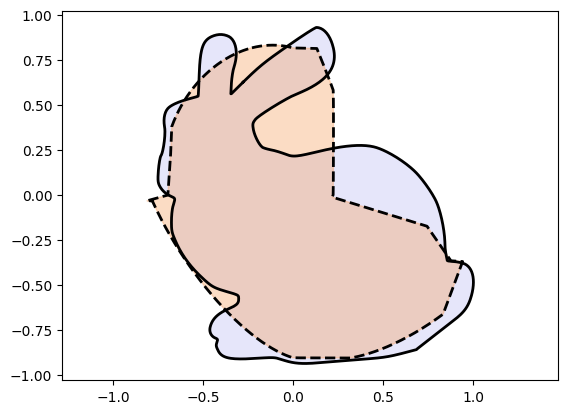

In [55]:
from assets.shapes import stanford_bunny

# Generate target curve points
num_pts = 1000
t = torch.linspace(0, 1, num_pts).reshape(-1, 1)
Xt_bunny = stanford_bunny(num_pts)

bunny_net = InjectiveNet(layer_count = 4, act_fn = nn.LeakyReLU)

automate_training(
    model = bunny_net, loss_fn = gs.MSELoss(), X_train = t, Y_train = Xt_bunny,
    learning_rate = 0.1, epochs = 1000, print_cost_every = 200
)

Xc_bunny = bunny_net(t)
plot_curves(Xc_bunny, Xt_bunny)

We observe very poor performance❗⚠️

If you played around with the code above you would have observed that Injective Networks on their
own:
- can get stuck in local optima.
- can fail to be expressive enough.

(why_prelu)=
To get ideas on improving the parameterization we first "*cheat*" a little and use the
`PReLU`[^prelu] activation function. `PReLU` has a learnable slope parameter $\alpha$ which can
during training become negative and therefore violate the injectivity property required from the
activation function for non-self intersection. Therefore, in general `PReLU` cannot be used in
Injective Networks but we use it here to gain insights into improving the method further.

[^prelu]: [PyTorch PReLU](https://pytorch.org/docs/stable/generated/torch.nn.PReLU.html)
    :::{blockquote}
    Applies the element-wise PReLU function.

    $$
    \text{PReLU}(x) = \max(0,x) + a * \min(0,x)
    $$

    or

    $$
    \text{PReLU}(x) =
    \begin{cases}
    x, & \text{ if } x \ge 0 \\
    ax, & \text{ otherwise }
    \end{cases}
    $$

    Here $a$ is a learnable parameter. When called without arguments, `nn.PReLU()` uses a single
    parameter $a$ across all input channels.
    :::

Epoch: [   1/1000]. Loss:    0.409880
Epoch: [ 200/1000]. Loss:    0.012553
Epoch: [ 400/1000]. Loss:    0.006243
Epoch: [ 600/1000]. Loss:    0.004879
Epoch: [ 800/1000]. Loss:    0.003924
Epoch: [1000/1000]. Loss:    0.002606


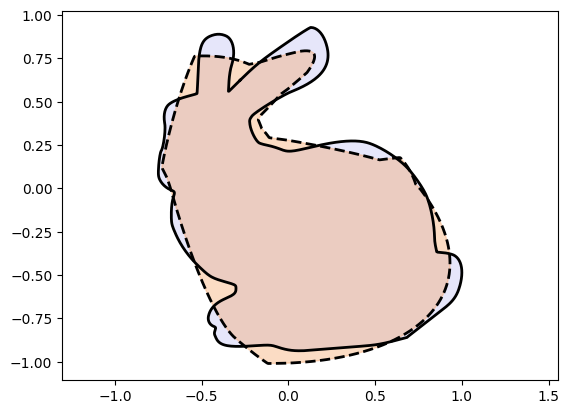

In [56]:
from assets.shapes import stanford_bunny

# Generate target curve points
num_pts = 1000
t = torch.linspace(0, 1, num_pts).reshape(-1, 1)
Xt_bunny = stanford_bunny(num_pts)

bunny_net = InjectiveNet(layer_count = 5, act_fn = nn.PReLU)

automate_training(
    model = bunny_net, loss_fn = gs.MSELoss(), X_train = t, Y_train = Xt_bunny,
    learning_rate = 0.1, epochs = 1000, print_cost_every = 200
)

Xc_bunny = bunny_net(t)
plot_curves(Xc_bunny, Xt_bunny)

(parameter_insight)=
We see an exciting improvement! Injective Networks with `PReLU` do much better. This gives us the
following insight:
:::{card}
Injective Networks are **parameter deficient**.

Adding parameters gives them much more representation power.
:::

We now address this problem of parameter deficiency and solve it using **Monotonic Networks**.